## Preprocessing

#### Download Libraries

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import nltk
nltk.download('stopwords')

import nltk
nltk.download('punkt')

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
!pip install scikit-plot

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stemmerPorter = PorterStemmer()
stemmerSnow = nltk.SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statistics
from scipy.interpolate import make_interp_spline, BSpline

#### Load and explore datasets

In [6]:
train_csv = '/content/gdrive/My Drive/datasets/vaccine_train_set.csv'

test_csv = '/content/gdrive/My Drive/datasets/vaccine_validation_set.csv'

In [7]:
import pandas as pd

df_train = pd.read_csv(train_csv)
df_train = df_train.drop(['Unnamed: 0'], axis=1)

df_train.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


In [8]:
df_train.shape

(15976, 2)

In [9]:
df_test = pd.read_csv(test_csv)
df_test = df_test.drop(['Unnamed: 0'], axis=1)

df_test.head()

,tweet,label
0,@user They had a massive surge in with covid d...,1
1,Required vaccines for school: Parents and guar...,0
2,“@KCStar: Two more Johnson County children hav...,0
3,NV can do better. Which states are the best (a...,2
4,Nothing like killing ourselves w/ our own fear...,2


In [10]:
df_test.shape

(2282, 2)

#### Data Cleaning

In [11]:
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize as wt

stopWords = set(stopwords.words('english'))

In [12]:
def stem(data):
  f_data = []
  for row in range(data.shape[0]):
    merge = data.iloc[row, 0]
    tokenized_text = wt(merge)
    cleaned_text = []
    for word in tokenized_text:
      if word not in stopWords:
        cleaned_text.append(stemmerSnow.stem(word))
    final_text = ' '.join(cleaned_text)
    f_data.append(final_text)
  return data

def data_cleaning(df):
  df['tweet'] = df['tweet'].apply(lambda x : re.sub(r'http\S+', ' ', x))
  df['tweet'] = df['tweet'].apply(lambda x : re.sub(r'https\S+', ' ', x))
  # df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'@\S+', ' ', x))
  # df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub(r'#\S+', ' ', x))
  df['tweet'] = df['tweet'].str.lower()
  # df['cleaned_tweet'] = df['cleaned_tweet'].str.encode('ascii', 'ignore').str.decode('ascii')
  # df['cleaned_tweet'] = df['cleaned_tweet'].str.replace('[^\w\s@/:%.,_-]', ' ', flags=re.UNICODE)
  df['tweet'] = df['tweet'].str.replace(r'[^\w\s]+', ' ', regex=True)
  # df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'<[^>]+>', ' ', regex=True)
  # df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: re.sub(r"@[A-Za-z0-9]+", ' ', x))
  df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopWords)]))
  # df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\s+[a-zA-Z]\s+', ' ', regex=True)
  # df['cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x : re.sub('<.*?>',' ', x))
  # df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\d+', ' ', regex=True)
  # df['cleaned_tweet'] = df['cleaned_tweet'].str.replace(r'\s+', ' ', regex=True)
  stem(df)

In [13]:
data_cleaning(df_train)
data_cleaning(df_test)

In [14]:
df_train.head()

,tweet,label
0,sip n shop come thru right marjais popularnobo...,0
1,know family take covid19 vaccine anytime soon,1
2,msignorile immunizations mandatory period okla...,2
3,president obama spoke favor vaccination childr...,0
4,myfoxla arizona monitoring hundreds measles li...,0


In [15]:
df_test.head()

,tweet,label
0,user massive surge covid deaths immediately va...,1
1,required vaccines school parents guardians chi...,0
2,kcstar two johnson county children measles set...,0
3,nv better states best worst vaccinating kids,2
4,nothing like killing w fear mt alyssa_milano v...,2


#### Store new datasets

In [16]:
df_train.to_csv('cleaned_train.csv', index=False)
df_test.to_csv('cleaned_test.csv', index=False)

## Glove Embeddings

In [17]:
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-03-14 21:56:39--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-14 21:56:39--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.17MB/s    in 2m 39s  

2022-03-14 21:59:19 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

In [18]:
from torchtext.legacy.data import Field, LabelField, Pipeline, TabularDataset
import torch

TEXT = Field(tokenize="spacy", batch_first=True)
LABEL = LabelField()

train_data, test_data = TabularDataset.splits( 
    path="", 
    train="cleaned_train.csv", 
    test="cleaned_test.csv",
    format="csv", 
    skip_header=True,
    fields=[('tweet', TEXT), ('label', LABEL)])

print("Train dataset shape:", len(train_data))
print("Test dataset shape:", len(test_data))

Train dataset shape: 15976
Test dataset shape: 2282


In [19]:
## please change when using other dataset
GLOVE_DATASET = 'glove.6B.200d'
D_EMB = 200

In [43]:
TEXT.build_vocab(train_data, vectors=GLOVE_DATASET)
# LABEL.build_vocab(train_data)
LABEL.build_vocab(train_data)
for i in range (3):
  LABEL.vocab.stoi[str(i)] = i

print("TEXT shape:", len(TEXT.vocab))
print("LABEL shape:", len(LABEL.vocab))

TEXT shape: 24529
LABEL shape: 3


In [44]:
LABEL.vocab.stoi

defaultdict(None, {'0': 0, '1': 1, '2': 2})

## RNN Models

#### Run on GPU 

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available for running: ')
print(device)

Device available for running: 
cpu


#### Load datasets in BuckerIterator

In [46]:
from torchtext.legacy.data import BucketIterator

BATCH_SIZE = 1024
TRAIN_BATCH_SIZE = BATCH_SIZE
TEST_BATCH_SIZE = BATCH_SIZE

train_itr, test_itr = BucketIterator.splits (
    (train_data, test_data), batch_sizes=(TRAIN_BATCH_SIZE, TEST_BATCH_SIZE),
    sort_key=lambda x:len(x.tweet,), shuffle=True,
    sort_within_batch=True, device=device)

print("Batches of train dataset:", len(train_itr))
print("Batches of test dataset:", len(test_itr))

Batches of train dataset: 16
Batches of test dataset: 3


#### Attention Mechanism

In [47]:
import torch.nn as nn
import torch.nn.functional as F
import math

# Implements the attention mechanism from https://arxiv.org/abs/1703.03130.
class Attention(nn.Module):
  # Initialize the weights of the Attention Mechanism.
  def __init__(self, rnn_dim, sequence_len, mean=0.0, std=0.05):
    super(Attention, self).__init__()
    self.Ws1 = nn.Parameter(torch.Tensor(BATCH_SIZE, rnn_dim))
    self.Ws2 = nn.Parameter(torch.Tensor(sequence_len, BATCH_SIZE))
    self.Ws1.data.normal_(mean, std)
    self.Ws2.data.normal_(mean, std)
  
  # Takes the output of RNN and passes it through the attention mechanism
  def forward(self, x):
      attn_out = torch.matmul(self.Ws1, x.permute(0, 2, 1))
      attn_out = torch.tanh(attn_out)
      attn_out = torch.matmul(self.Ws2, attn_out)
      attn_out = F.softmax(attn_out, dim=2)
      attn_out = torch.bmm(attn_out, x)
      return attn_out

#### RNN implementation

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import math

# Implements two types of RNNs: Bi-LSTM & GRU.
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, sequence_len, dropout_prob, glove_embeddings):
        super(RNN, self).__init__()
        # embedding layer
        self.glove_emb = torch.nn.Embedding(input_dim, sequence_len)
        self.glove_emb.weight = torch.nn.Parameter(glove_embeddings, requires_grad=False)
        # rnn hidden dimensions (128)
        self.hidden_dim = hidden_dim
        # number of stucked rnns
        self.num_layers = num_layers
        # output dimensions (3)
        self.output_dim = output_dim
        # length of sequence (DEMB: 200)
        self.sequence_len = sequence_len
        # initilize dropout
        self.dropout = nn.Dropout(dropout_prob)

class RNN_LSTM(RNN):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, sequence_len, dropout_prob, glove_embeddings, self_attention=True):
    super(RNN_LSTM, self).__init__(input_dim, hidden_dim, output_dim, num_layers, sequence_len, dropout_prob, glove_embeddings)
    # initialize LSTM
    self.lstm = nn.LSTM(self.sequence_len, self.hidden_dim, self.num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob)
    # initialize linear layer
    self.fc = nn.Linear(self.hidden_dim*2, self.output_dim)
    # initialize attention layer
    if self_attention:
      self.attention_layer = Attention(self.hidden_dim*2, self.sequence_len)
    else:
      self.attention_layer = None

  def forward(self, x):
      # get input embedding
      x = self.glove_emb(x)
      # initilize hidden and cell states to zero tensors
      h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(device)
      c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(device)
      # retrieve output features (h_t) from the last layer of the LSTM
      out, _ = self.lstm(x, (h0.detach(), c0.detach()))
      # pass output features through attention mechanism
      if self.attention_layer != None:
        out = self.attention_layer(out)
      # get the last hidden state
      out = out[:,-1,:]
      # dropout layer
      out = self.dropout(out)
      # linear layer
      out = self.fc(out)
      # output tensor
      return out

class RNN_GRU(RNN):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers, sequence_len, dropout_prob, glove_embeddings, self_attention=True):
    super(RNN_GRU, self).__init__(input_dim, hidden_dim, output_dim, num_layers, sequence_len, dropout_prob, glove_embeddings)
    # initialize GRU
    self.gru = nn.GRU(self.sequence_len, self.hidden_dim, self.num_layers, batch_first=True, dropout=dropout_prob)
    # initialize linear layer
    self.fc = nn.Linear(self.hidden_dim, self.output_dim)
    # initialize attention layer
    if self_attention:
      self.attention_layer = Attention(self.hidden_dim, self.sequence_len)
    else:
      self.attention_layer = None

  def forward(self, x):
      # get input embedding
      x = self.glove_emb(x)
      # initilize hidden and cell states to zero tensors
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
      # retrieve output features (h_t) from the last layer of the GRU
      out, _ = self.gru(x, h0.detach())
      # pass output features through attention mechanism
      if self.attention_layer != None:
        out = self.attention_layer(out)
      # get the last hidden state
      out = out[:,-1,:]
      # dropout layer
      out = self.dropout(out)
      # linear layer
      out = self.fc(out)
      # output tensor
      return out

#### Experiment Class 


> performs RNN train and evaluation methods



In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
import scikitplot as skplt
import numpy as np

class Experiments():
  def __init__(self, model, epochs, criterion, optimizer, train_dataloader, test_dataloader, clip):
    # feed forward neural network
    self.nn = model
    # train parameters
    self.epochs = epochs
    self.criterion = criterion
    self.optimizer = optimizer
    self.clip = clip
    # datasets
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    # stats
    self.train_scores = {'loss':[], 'accuracy':[], 'predicted_labels':[], 'actual_labels':[]}
    self.val_scores = {'loss':[], 'accuracy':[], 'predicted_labels':[], 'actual_labels':[]}

  def get_pred_labels(self, out):
    # apply softmax before obtaining results
    soft_pred = torch.log_softmax(out, dim=1)
    # get prediction labels
    _, pred = torch.max(out, dim=1)
    return pred
  
  def compute_accuracy(self, labels, pred):
    correct = (pred == labels).float()
    accuracy = correct.sum() / len(correct)
    return accuracy
  
  def compute_scores(self, accuracy, loss, n, pred, actual, contrainer):
    contrainer['accuracy'].append(accuracy/n)
    contrainer['loss'].append(loss/n)
    contrainer['predicted_labels'].append(np.concatenate(pred).ravel().tolist())
    contrainer['actual_labels'].append(np.concatenate(actual).ravel().tolist())

  def get_train_scores(self):
    return self.train_scores
  
  def get_validation_scores(self):
    return self.val_scores
  
  def epoch_report(self, epoch, method = 'train'):
    if method == 'train':
      print('====')
      print('Classification report for train set')
      print('====')
      print(classification_report(self.train_scores['actual_labels'][epoch-1], self.train_scores['predicted_labels'][epoch-1]))
    else:
      print('====')
      print('Classification report for validation set')
      print('====')
      print(classification_report(self.val_scores['actual_labels'][epoch-1], self.val_scores['predicted_labels'][epoch-1]))

  def plot_roc_curves(self, iter):
    for X, y in iter:
      X = X.to(device)
      pred = self.nn.forward(X).cpu().detach().numpy()
      skplt.metrics.plot_roc(y.cpu(), pred)
  
  def plot_loss_curves(self):
    plt.figure(figsize=(10,10))
    plt.title("Training / Validation Loss Curves")
    plt.plot(self.train_scores['loss'],'-b')
    plt.plot(self.val_scores['loss'],'-g')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(('Training','Validation'), loc='upper right', fontsize='x-large')
    plt.show()

  def run(self):
    # iterate for each epoch
    for epoch in range(self.epochs):
      # train mode
      self.nn.train()
      train_loss = 0
      train_pred = []
      train_actual = []
      train_accuracy = 0
      # train per batches
      for item in self.train_dataloader:
        X = item.tweet.to(device)
        y = item.label.to(device)
        # forward pass
        out = self.nn.forward(X)
        loss = self.criterion(out, y)
        # backward pass and update
        self.optimizer.zero_grad()
        loss.backward(retain_graph=True)
        if self.clip != 0:
          torch.nn.utils.clip_grad_norm_(self.nn.parameters(), self.clip)
        self.optimizer.step()
        # stats
        batch_pred = self.get_pred_labels(out)
        train_accuracy += self.compute_accuracy(y, batch_pred)
        train_loss += loss.item()
        train_pred.append(batch_pred.cpu().numpy())
        train_actual.append(y.cpu().numpy())
      # compute final stats
      self.compute_scores(train_accuracy, train_loss, len(self.train_dataloader), train_pred, train_actual, self.train_scores)

      # evaluation mode
      self.nn.eval()
      # predict on validation set
      with torch.no_grad():
        val_loss = 0
        val_pred = []
        val_actual = []
        val_accuracy = 0
        # evaluate per batches
        for item in self.test_dataloader:
          X_val = item.tweet.to(device)
          y_val = item.label.to(device)
          # get predictions
          out = self.nn.forward(X_val)
          loss = self.criterion(out, y_val)
          # stats
          batch_pred = self.get_pred_labels(out)
          val_accuracy += self.compute_accuracy(y_val, batch_pred)
          val_loss += loss.item()
          val_pred.append(batch_pred.cpu().numpy())
          val_actual.append(y_val.cpu().numpy())
        # compute final stats
        self.compute_scores(val_accuracy, val_loss, len(self.test_dataloader), val_pred, val_actual, self.val_scores)
      
      print("Validation Epoch" , epoch, " | Train Loss:", self.train_scores['loss'][epoch], "Train Accuracy:", self.train_scores['accuracy'][epoch].cpu().numpy(), " | Validation Loss:", self.val_scores['loss'][epoch], "Validation Accuracy:", self.val_scores['accuracy'][epoch].cpu().numpy())


## Experiments

### Experiments on GRU

#### Grid Search of parameters on GRU


In [26]:
"""
input_dim = len(TEXT.vocab)
hidden_sizes = [128]
output_size = 3

glove_embeddings = TEXT.vocab.vectors
sequence_len = D_EMB

num_stacked = [2]
dropout_prob = [0.5, 0.7, 0.8]
clipping = [0.5, 1, 1.5, 5, 10]
lrs = [1e-3, 2e-3, 1e-3, 2e-4]

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

n_epochs = 8

for hidden_size in hidden_sizes:
  for n_stacked in num_stacked:
    for drop_p in dropout_prob:
      for clip in clipping:
        for learning_rate in lrs:
          rnn = RNN_GRU(input_dim, hidden_size, output_size, n_stacked, sequence_len, drop_p, TEXT.vocab.vectors, self_attention=False)
          rnn = rnn.to(device)
          optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
          
          print("Case: hidden size:", hidden_size, "num stacked:", n_stacked, "dropout prob:", drop_p, "clipping:", clip, "learning rate:", learning_rate)
          print()

          exp = Experiments(rnn, n_epochs, criterion, optimizer, train_itr, test_itr, clip)
          exp.run()

          print()
          exp.plot_loss_curves()
          print()
          exp.epoch_report(8, 'val')
          print()
          print()
"""

'\ninput_dim = len(TEXT.vocab)\nhidden_sizes = [128]\noutput_size = 3\n\nglove_embeddings = TEXT.vocab.vectors\nsequence_len = D_EMB\n\nnum_stacked = [2]\ndropout_prob = [0.5, 0.7, 0.8]\nclipping = [0.5, 1, 1.5, 5, 10]\nlrs = [1e-3, 2e-3, 1e-3, 2e-4]\n\ncriterion = nn.CrossEntropyLoss()\ncriterion = criterion.to(device)\n\nn_epochs = 8\n\nfor hidden_size in hidden_sizes:\n  for n_stacked in num_stacked:\n    for drop_p in dropout_prob:\n      for clip in clipping:\n        for learning_rate in lrs:\n          rnn = RNN_GRU(input_dim, hidden_size, output_size, n_stacked, sequence_len, drop_p, TEXT.vocab.vectors, self_attention=False)\n          rnn = rnn.to(device)\n          optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)\n          \n          print("Case: hidden size:", hidden_size, "num stacked:", n_stacked, "dropout prob:", drop_p, "clipping:", clip, "learning rate:", learning_rate)\n          print()\n\n          exp = Experiments(rnn, n_epochs, criterion, optimiz

#### Best GRU model



*   Hidden size: 128
*   Stacked RNNs: 2
*   Dropout Pr: 0.7
*   Clip: 0.5
*   Learining Rate: 0.001

Validation Epoch 0  | Train Loss: 0.9978789277374744 Train Accuracy: 0.495982  | Validation Loss: 0.9985355138778687 Validation Accuracy: 0.5041344
Validation Epoch 1  | Train Loss: 0.8979198336601257 Train Accuracy: 0.5956524  | Validation Loss: 0.9359548290570577 Validation Accuracy: 0.53583235
Validation Epoch 2  | Train Loss: 0.8279296085238457 Train Accuracy: 0.63404506  | Validation Loss: 0.8966233531634012 Validation Accuracy: 0.5537777
Validation Epoch 3  | Train Loss: 0.7873756848275661 Train Accuracy: 0.6512554  | Validation Loss: 0.818896472454071 Validation Accuracy: 0.63228667
Validation Epoch 4  | Train Loss: 0.7689924240112305 Train Accuracy: 0.650565  | Validation Loss: 0.8112843632698059 Validation Accuracy: 0.64115924
Validation Epoch 5  | Train Loss: 0.7418881841003895 Train Accuracy: 0.67003363  | Validation Loss: 0.7877723773320516 Validation Accuracy: 0.64372164
Validation Epoch 6  | Train Loss: 0.7259220220148563 Train Accuracy: 0.68259025  | Validation Loss: 0.7

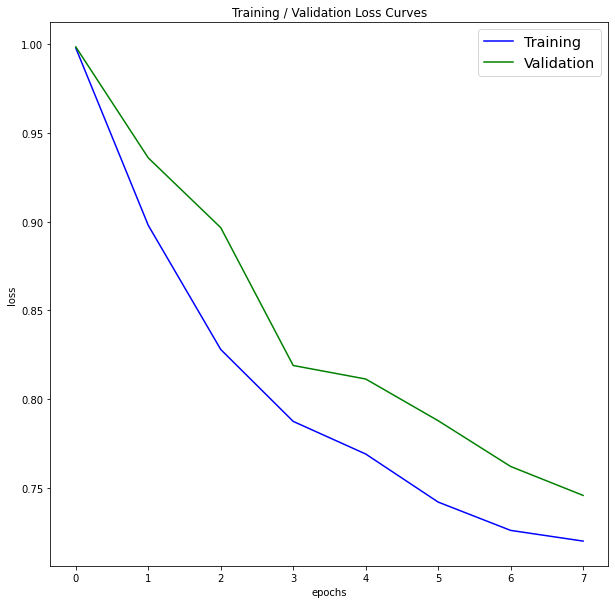


====
Classification report for validation set
====
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1065
           1       0.44      0.26      0.32       296
           2       0.64      0.79      0.71       921

    accuracy                           0.70      2282
   macro avg       0.63      0.60      0.60      2282
weighted avg       0.70      0.70      0.69      2282



In [50]:
input_dim = len(TEXT.vocab)
hidden_size = 128
output_size = 3

glove_embeddings = TEXT.vocab.vectors
sequence_len = D_EMB

n_stacked = 2
dropout_prob = 0.7
clip = 0.5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

n_epochs = 8
rnn_gru = RNN_GRU(input_dim, hidden_size, output_size, n_stacked, sequence_len, dropout_prob, TEXT.vocab.vectors, self_attention=False)
rnn_gru = rnn_gru.to(device)
optimizer = torch.optim.Adam(rnn_gru.parameters(), lr=learning_rate)

exp_gru = Experiments(rnn_gru, n_epochs, criterion, optimizer, train_itr, test_itr, clip)
exp_gru.run()

print()
exp_gru.plot_loss_curves()
print()
exp_gru.epoch_report(8, 'val')

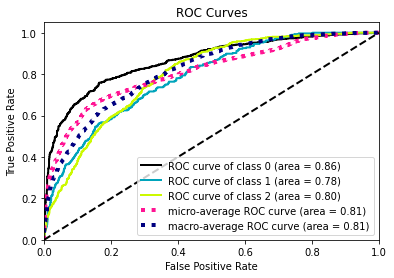

In [51]:
iterator = BucketIterator (dataset=test_data, batch_size=(2282), sort_key=lambda x:len(x.tweet,), shuffle=True, sort_within_batch=True, device=device)
exp_gru.plot_roc_curves(iterator)

#### Best GRU model with Attention

Validation Epoch 0  | Train Loss: 0.9988927580416203 Train Accuracy: 0.48341033  | Validation Loss: 0.9720354676246643 Validation Accuracy: 0.5528902
Validation Epoch 1  | Train Loss: 0.8820187263190746 Train Accuracy: 0.60808694  | Validation Loss: 0.8435504833857218 Validation Accuracy: 0.6203231
Validation Epoch 2  | Train Loss: 0.8036439679563046 Train Accuracy: 0.64132494  | Validation Loss: 0.8078112602233887 Validation Accuracy: 0.6241069
Validation Epoch 3  | Train Loss: 0.781887125223875 Train Accuracy: 0.65624285  | Validation Loss: 0.7739571134249369 Validation Accuracy: 0.64148474
Validation Epoch 4  | Train Loss: 0.7518652342259884 Train Accuracy: 0.6690864  | Validation Loss: 0.7562790711720785 Validation Accuracy: 0.65296143
Validation Epoch 5  | Train Loss: 0.7322471216320992 Train Accuracy: 0.6786903  | Validation Loss: 0.7508234779040018 Validation Accuracy: 0.6724954
Validation Epoch 6  | Train Loss: 0.7185390703380108 Train Accuracy: 0.6886319  | Validation Loss: 0.

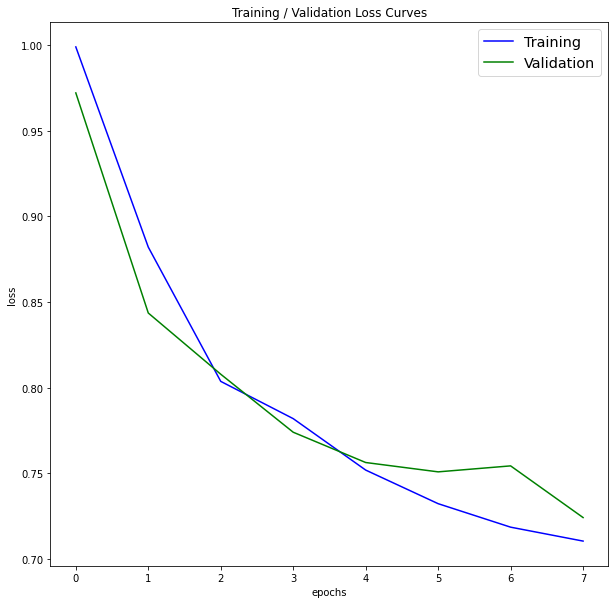


====
Classification report for validation set
====
              precision    recall  f1-score   support

           0       0.80      0.73      0.77      1065
           1       0.55      0.25      0.34       296
           2       0.63      0.80      0.71       921

    accuracy                           0.70      2282
   macro avg       0.66      0.59      0.60      2282
weighted avg       0.70      0.70      0.69      2282



In [52]:
input_dim = len(TEXT.vocab)
hidden_size = 128
output_size = 3

glove_embeddings = TEXT.vocab.vectors
sequence_len = D_EMB

n_stacked = 2
dropout_prob = 0.7
clip = 0.5
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

n_epochs = 8
rnn_attn = RNN_GRU(input_dim, hidden_size, output_size, n_stacked, sequence_len, dropout_prob, TEXT.vocab.vectors, self_attention=True)
rnn_attn = rnn_attn.to(device)
optimizer = torch.optim.Adam(rnn_attn.parameters(), lr=learning_rate)

exp_attn = Experiments(rnn_attn, n_epochs, criterion, optimizer, train_itr, test_itr, clip)
exp_attn.run()

print()
exp_attn.plot_loss_curves()
print()
exp_attn.epoch_report(8, 'val')

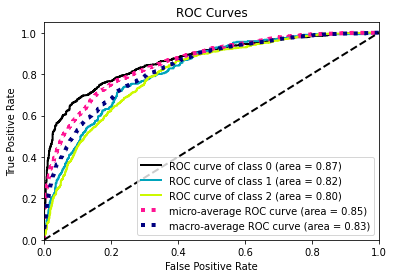

In [53]:
iterator = BucketIterator (dataset=test_data, batch_size=(2282), sort_key=lambda x:len(x.tweet,), shuffle=True, sort_within_batch=True, device=device)
exp_attn.plot_roc_curves(iterator)

### Experiments on LSTM

#### Grid Search of parameters on LSTM


In [31]:
"""
input_dim = len(TEXT.vocab)
hidden_sizes = [128]
output_size = 3

glove_embeddings = TEXT.vocab.vectors
sequence_len = D_EMB

num_stacked = [2]
dropout_prob = [0.2, 0.7, 0.8]
clipping = [0.5, 1, 1.5, 5]
lrs = [1e-3, 2e-3, 1e-3, 2e-4]

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(df_train.label), y=df_train.label)
class_weights = torch.tensor(class_weights,dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='mean')

# criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

n_epochs = 8

for hidden_size in hidden_sizes:
  for n_stacked in num_stacked:
    for drop_p in dropout_prob:
      for clip in clipping:
        for learning_rate in lrs:
          rnn = RNN_LSTM(input_dim, hidden_size, output_size, n_stacked, sequence_len, drop_p, TEXT.vocab.vectors, self_attention=False)
          rnn = rnn.to(device)
          optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
          
          print("Case: hidden size:", hidden_size, "num stacked:", n_stacked, "dropout prob:", drop_p, "clipping:", clip, "learning rate:", learning_rate)
          print()

          exp = Experiments(rnn, n_epochs, criterion, optimizer, train_itr, test_itr, clip)
          exp.run()

          print()
          exp.plot_loss_curves()
          print()
          exp.epoch_report(8, 'val')
          print()
          print()
"""

'\ninput_dim = len(TEXT.vocab)\nhidden_sizes = [128]\noutput_size = 3\n\nglove_embeddings = TEXT.vocab.vectors\nsequence_len = D_EMB\n\nnum_stacked = [2]\ndropout_prob = [0.2, 0.7, 0.8]\nclipping = [0.5, 1, 1.5, 5]\nlrs = [1e-3, 2e-3, 1e-3, 2e-4]\n\nclass_weights = class_weight.compute_class_weight(class_weight=\'balanced\', classes=np.unique(df_train.label), y=df_train.label)\nclass_weights = torch.tensor(class_weights,dtype=torch.float)\ncriterion = nn.CrossEntropyLoss(weight=class_weights, reduction=\'mean\')\n\n# criterion = nn.CrossEntropyLoss()\ncriterion = criterion.to(device)\n\nn_epochs = 8\n\nfor hidden_size in hidden_sizes:\n  for n_stacked in num_stacked:\n    for drop_p in dropout_prob:\n      for clip in clipping:\n        for learning_rate in lrs:\n          rnn = RNN_LSTM(input_dim, hidden_size, output_size, n_stacked, sequence_len, drop_p, TEXT.vocab.vectors, self_attention=False)\n          rnn = rnn.to(device)\n          optimizer = torch.optim.Adam(rnn.parameters(),

#### Best LSTM model

Validation Epoch 0  | Train Loss: 1.0284339934587479 Train Accuracy: 0.4294933  | Validation Loss: 1.0073017080624898 Validation Accuracy: 0.45436868
Validation Epoch 1  | Train Loss: 0.9185571819543839 Train Accuracy: 0.59156466  | Validation Loss: 0.9346658984820048 Validation Accuracy: 0.5384365
Validation Epoch 2  | Train Loss: 0.8500558659434319 Train Accuracy: 0.6218975  | Validation Loss: 0.901937743028005 Validation Accuracy: 0.55019695
Validation Epoch 3  | Train Loss: 0.8168023377656937 Train Accuracy: 0.63862115  | Validation Loss: 0.8998984495798746 Validation Accuracy: 0.5439286
Validation Epoch 4  | Train Loss: 0.7967936508357525 Train Accuracy: 0.64299506  | Validation Loss: 0.8366490801175436 Validation Accuracy: 0.6253283
Validation Epoch 5  | Train Loss: 0.7617833390831947 Train Accuracy: 0.65478754  | Validation Loss: 0.8141742547353109 Validation Accuracy: 0.61584646
Validation Epoch 6  | Train Loss: 0.7375620976090431 Train Accuracy: 0.67231894  | Validation Loss: 

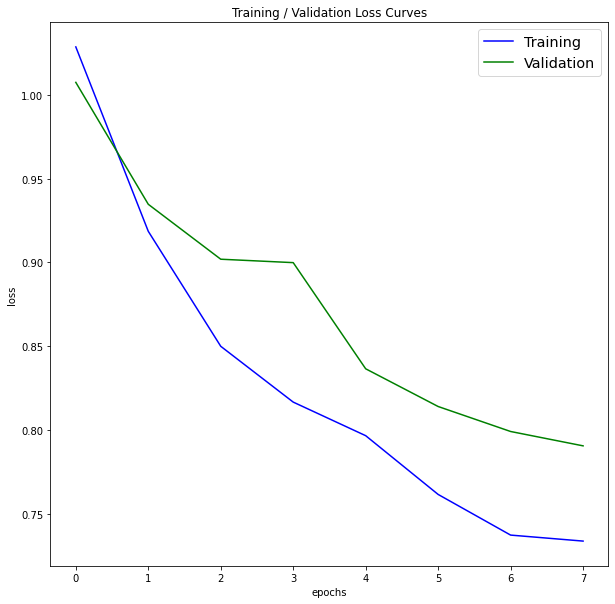


====
Classification report for validation set
====
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1065
           1       0.33      0.30      0.32       296
           2       0.62      0.77      0.69       921

    accuracy                           0.66      2282
   macro avg       0.59      0.58      0.58      2282
weighted avg       0.67      0.66      0.66      2282



In [54]:
from sklearn.utils import class_weight

input_dim = len(TEXT.vocab)
hidden_size = 128
output_size = 3

glove_embeddings = TEXT.vocab.vectors
sequence_len = D_EMB

n_stacked = 2
dropout_prob = 0.7
clip = 1
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

n_epochs = 8
rnn_lstm = RNN_LSTM(input_dim, hidden_size, output_size, n_stacked, sequence_len, dropout_prob, TEXT.vocab.vectors, self_attention=False)
rnn_lstm = rnn_lstm.to(device)
optimizer = torch.optim.Adam(rnn_lstm.parameters(), lr=learning_rate)

exp_lstm_1 = Experiments(rnn_lstm, n_epochs, criterion, optimizer, train_itr, test_itr, clip)
exp_lstm_1.run()

print()
exp_lstm_1.plot_loss_curves()
print()
exp_lstm_1.epoch_report(8, 'val')

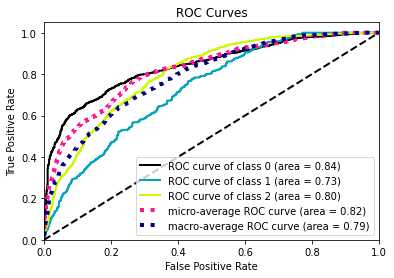

In [55]:
iterator = BucketIterator (dataset=test_data, batch_size=(2282), sort_key=lambda x:len(x.tweet,), shuffle=True, sort_within_batch=True, device=device)
exp_lstm_1.plot_roc_curves(iterator)

#### Best LSTM model with attention

Validation Epoch 0  | Train Loss: 1.00771489366889 Train Accuracy: 0.51182973  | Validation Loss: 0.9561183849970499 Validation Accuracy: 0.562372
Validation Epoch 1  | Train Loss: 0.8789208456873894 Train Accuracy: 0.61807215  | Validation Loss: 0.842943032582601 Validation Accuracy: 0.6282608
Validation Epoch 2  | Train Loss: 0.81647028028965 Train Accuracy: 0.6356883  | Validation Loss: 0.8023601770401001 Validation Accuracy: 0.6393702
Validation Epoch 3  | Train Loss: 0.7721096575260162 Train Accuracy: 0.653589  | Validation Loss: 0.777696430683136 Validation Accuracy: 0.64396644
Validation Epoch 4  | Train Loss: 0.7441056184470654 Train Accuracy: 0.6726288  | Validation Loss: 0.7522462407747904 Validation Accuracy: 0.65939116
Validation Epoch 5  | Train Loss: 0.7247588001191616 Train Accuracy: 0.68302226  | Validation Loss: 0.7636700868606567 Validation Accuracy: 0.64848477
Validation Epoch 6  | Train Loss: 0.7049884274601936 Train Accuracy: 0.69155926  | Validation Loss: 0.723571

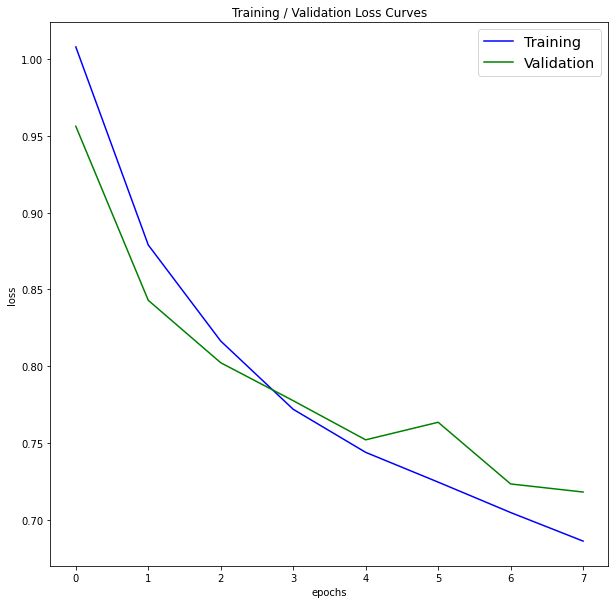


====
Classification report for validation set
====
              precision    recall  f1-score   support

           0       0.79      0.76      0.77      1065
           1       0.48      0.34      0.40       296
           2       0.65      0.74      0.69       921

    accuracy                           0.70      2282
   macro avg       0.64      0.61      0.62      2282
weighted avg       0.69      0.70      0.69      2282



In [56]:
input_dim = len(TEXT.vocab)
hidden_size = 128
output_size = 3

glove_embeddings = TEXT.vocab.vectors
sequence_len = D_EMB

n_stacked = 2
dropout_prob = 0.7
clip = 1
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

n_epochs = 8
rnn_lstm = RNN_LSTM(input_dim, hidden_size, output_size, n_stacked, sequence_len, dropout_prob, TEXT.vocab.vectors, self_attention=True)
rnn_lstm = rnn_lstm.to(device)
optimizer = torch.optim.Adam(rnn_lstm.parameters(), lr=learning_rate)

exp_lstm_attn = Experiments(rnn_lstm, n_epochs, criterion, optimizer, train_itr, test_itr, clip)
exp_lstm_attn.run()

print()
exp_lstm_attn.plot_loss_curves()
print()
exp_lstm_attn.epoch_report(8, 'val')

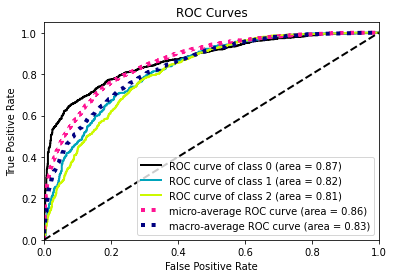

In [57]:
exp_lstm_attn.plot_roc_curves(iterator)